In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from time import strftime

import matplotlib.dates as mdates
from scipy.signal import medfilt

# %matplotlib

In [2]:
ms = [10.257, 10.3, 10.29]
bs = [-12.2, -10.2, -8.4]

LABELS = ["Baño interno", "Baño externo", "Ambiente"]

CYCLE = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
def loadData(file_name, time_adjust = 0, is_in_temperature = True):
    string = np.genfromtxt(file_name, delimiter = "\t", skip_header = 1, dtype = str)
    times = string[:, 0]
    
    times = [datetime.strptime(text, "%Y-%m-%d %H:%M:%S") - timedelta(hours = time_adjust) for text in times]
    data = string[:, 1:].astype(float)
    if not is_in_temperature:
        data = data * 1000
        data = dataToTemperature(data)
    return times, data

def dataToTemperature(data):
    for i in range(3):
        data[:, i] = (data[:, i] - bs[i]) / ms[i]
    return data.round(2)

def makeTimeAxis(fig, ax):
    date_format = mdates.DateFormatter('%d/%H:%M')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_minor_formatter(date_format)
    ax.set_xlabel("Día/Hora")
    fig.autofmt_xdate()
    
def plotTemperatureInTime(time, data, figsize = (8, 4.5), plot_ambient = True):
    fig, ax = plt.subplots(figsize = figsize)
    n = 2
    if plot_ambient: n = 3
    for i in range(n):
        ax.plot(time, data[:, i], label = LABELS[i])

    makeTimeAxis(fig, ax)

    ax.legend()
    
    ax.set_ylabel("Temperatura ($^\circ$C)")

#     ax.grid()
    
    fig.tight_layout()

    return fig, ax

def makeCompiled(time, data):
    with open("Compiled.txt", "w") as file:
        file.write("Datetime\tInner Bath (C)\tExternal Bath (C)\tAmbient (C)")
        line = [""]*4
        for (t, d) in zip(time, data):
            line[0] = t.strftime("%Y-%m-%d %H:%M:%S")
            line[1:] = ["%.2f"%val for val in d]
            file.write("\t".join(line) + "\r\n")
            
def unify(files, times):
    times_ = np.zeros((0))
    datas = np.zeros((0, 3))
    for (file, time) in zip(files, times):
        t, d = loadData(file, time)
        times_ = np.append(times_, t)
        datas = np.append(datas, d, axis = 0)
    _, pos = np.unique(times_, return_index=True)
    return times_[pos], datas_[pos]

def unifyLoaded(times, datas):
    times_ = np.zeros((0))
    datas_ = np.zeros((0, 3))
    for (t, d) in zip(times, datas):
        times_ = np.append(times_, t)
        datas_ = np.append(datas_, d, axis = 0)
    _, pos = np.unique(times_, return_index=True)
    return times_[pos], datas_[pos]

def filterZone(min, max, data, size = 1000):
    data[min : max, 0] = (data[min - size : min, 0].mean() + data[max : max + size, 0].mean()) / 2
    
    return data

# Time, Data / 10 - Oct 

In [4]:
time, data = loadData("TemperatureData.txt")

In [5]:
data2 = data.copy()

In [6]:
data2 = filterZone(25000, 35000, data2)
data2 = filterZone(75000, 81000, data2)

data2 = medfilt(data2, [251, 1])

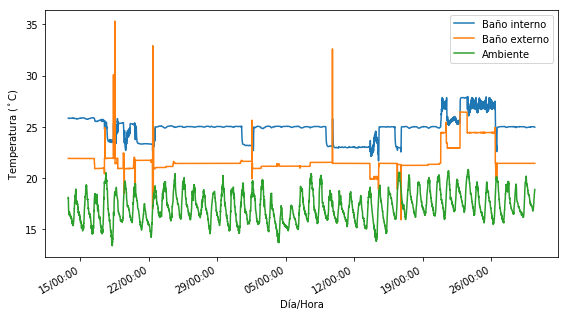

In [7]:
fig, ax = plotTemperatureInTime(time, data2)
# fig.savefig("Stability.png", dpi = 300)
plt.show()

# Always

In [ ]:
time_c, data_c = loadData("Compiled.txt")

In [ ]:
DOWNSAMPLE = 100

fig, ax = plotTemperatureInTime(time_c[::DOWNSAMPLE], data_c[::DOWNSAMPLE])
fig.savefig("Stability.png", dpi = 300)
plt.show()

# Ripple

In [ ]:
time, data = loadData('Compiled.txt')

In [ ]:
from_ = 800
to_ = 40000
fig, ax = plotTemperatureInTime(time[from_ : to_], data[from_ : to_], (5, 4.5), plot_ambient = False)
fig.savefig("temperatureRipple.png", dpi = 300)

In [ ]:
TIME, DATA = loadData('TemperatureData.txt')

# Sensibility

In [ ]:
from_ = 670000
to_ = 765000
every = 10
time, data = TIME[from_ : to_: every], DATA[from_ : to_ : every]

In [ ]:
data2 = data.copy()

data2 = medfilt(data2, [21, 1])

fig, ax = plotTemperatureInTime(time, data2, (5, 4.5), plot_ambient = False)
fig.savefig("temperatureSensibility.png", dpi = 300)

# Results

In [ ]:
from_ = 450000
to_ = 710000
every = 10
time, data = TIME[from_ : to_: every], DATA[from_ : to_ : every]

In [ ]:
data2 = data.copy()
data2 = medfilt(data2, [7, 1])

In [ ]:
interno = data2[:, 0]
mean, std = interno.mean(), interno.std()
print(mean, std)

In [ ]:
fig, ax = plt.subplots(figsize = (8, 4.5))

ax2 = ax.twinx()
for i in range(1, 3):
    ax.plot(time, data2[:, i], label = LABELS[i], c = CYCLE[i])

ax2.plot(time, data2[:, 0], label = LABELS[0], alpha = 0.5)
ax2.plot(time, [mean]*len(time), '--', label = 'Promedio', alpha = 1, color = CYCLE[0])

ax2.tick_params('y', colors = CYCLE[0])
    
ax.legend()
ax2.legend()
makeTimeAxis(fig, ax)
ax.set_xlabel('Tiempo (Dia/Hora)')
ax.set_ylabel('Temperatura ($^\circ$C)')
ax2.set_ylabel('Temperatura ($^\circ$C)', color = CYCLE[0])

fig.tight_layout()

fig.savefig("temperatureStability.png", dpi = 300)

In [ ]:
cov = np.cov(data2[:, 0], data[:, 2])
sigma_x = data2[:, 0].std()
sigma_y = data2[:, 2].std()
cov[0, 1] / (sigma_x * sigma_y)